# PINN: Singularly perturbed boundary value problem


In [18]:
!pip install torchaudio==0.13.0
!pip install torchvision==0.14.0
!pip install torchphysics

import torch
import torchphysics as tp
import math
torch.cuda.is_available()

True

In [19]:
X = tp.spaces.R1('x')
Y = tp.spaces.R1('y')
D = tp.spaces.R2('D')
A = tp.spaces.R2('a')

U = tp.spaces.R1('u')

In [20]:
h, w = 1, 1
eps = 0.1
R = -2

In [21]:
Ix = tp.domains.Interval(X, 0, w)
Iy = tp.domains.Interval(Y, 0, h)

A_xy = Ix * Iy
A_D = tp.domains.Parallelogram(D, [-1,-1], [-1.0,1], [1,-1.0])

Before we visualize the created domain, we create Sampler objects which are iterators that sample points from the domain during the optimization task. There are again various options to sample from the domains, an easy way would be to sample uniformly distributed random points. In this example, we choose an adaptive sampler to sample points in the inner of the domain. It will sample more points in points where the loss is large.

The amount of sampled points is defined by their density in the 3/2-dim subset, it could be increased to achieve better training results.

In [22]:
#inner_sampler = tp.samplers.AdaptiveRandomRejectionSampler(A_x*A_t*A_D, density=2)
inner_sampler = tp.samplers.RandomUniformSampler(A_xy*A_D, n_points=100000) #vorher n_points=100000 statt density

We visualize the domain through the points created by the samplers using matplotlib:

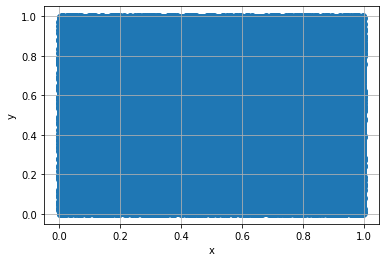

In [23]:
fig = tp.utils.scatter(X*Y, inner_sampler)

In [24]:
# apply boundary condition via hard constrains:
def constrain_fn(u,x,y):   
    u_con =  u *(x-w)/w * x/w * (y-h)/h *y/h
   
    return u_con

In the next step we define the NN-model we want to fit to the PDE. A normalization can improve convergence for large or small domains.

In [25]:
model = tp.models.Sequential(
    tp.models.NormalizationLayer(A_xy*A_D),
    tp.models.FCN(input_space=X*Y*D, output_space=U*A, hidden=(60, 60, 60, 60, 60, 60 ), 
                  xavier_gains=[5/3,5/3,5/3,5/3,5/3,0]))#,vorher 4 Netze mit 60

#if NN: 
    #model.load_state_dict(torch.load('PDE.pt')) #PDE_final; PDE_min_loss

Now, we define a condition which aims to minimze the mean squared error of the residual of the poisson equation. 

In [26]:
def pde_residual(u, a, x, y, D):
    u = constrain_fn(u,x,y)
    conv_term = torch.sum(D*tp.utils.grad(u, x, y), dim=1, keepdim=True)
    lap = tp.utils.div(a, x, y)
    return (eps**0.5)*lap - conv_term + R

pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=pde_residual,
                                            name='pde_condition')

def pde2_residual(u, a, x, y, D):
    u = constrain_fn(u,x,y)
    return a + (eps**0.5)*tp.utils.grad(u,x,y)

pde2_condition = tp.conditions.PINNCondition(module=model,
                                             sampler=inner_sampler,
                                             residual_fn=pde2_residual,
                                             name='pde2_condition')

Finally, we optimize the conditions using a pytorch-lightning.LightningModule Solver and running the training. In the Solver, the training and validation conditions, as well as all optimizer options can be specified.

In [27]:
optim = tp.solver.OptimizerSetting(torch.optim.Adam, lr=1e-3)
#optim = tp.solver.OptimizerSetting(torch.optim.LBFGS, lr=1e-2)#SGD, LBFGS
solver = tp.solver.Solver([pde_condition,pde2_condition], optimizer_setting = optim)

import pytorch_lightning as pl

#gpus='-1' if torch.cuda.is_available() else None
#accelerator='gpu', devices='-1'
trainer = pl.Trainer(gpus='1' if torch.cuda.is_available() else None,
                     max_steps=15000,
                     benchmark=True,
                     logger=True)
                     #checkpoint_callback=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 18.8 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
18.8 K    Trainable params
0         Non-trainable params
18.8 K    Total params
0.075     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [35]:
optim = tp.solver.OptimizerSetting(torch.optim.Adam, lr=1e-4)
#optim = tp.solver.OptimizerSetting(torch.optim.LBFGS, lr=1e-3)
#optim = tp.solver.OptimizerSetting(torch.optim.LBFGS, lr=1e-2)#SGD, LBFGS
solver = tp.solver.Solver([pde_condition,pde2_condition], optimizer_setting = optim)

import pytorch_lightning as pl

trainer = pl.Trainer(gpus=1 if torch.cuda.is_available else None,
                     max_steps=2000,
                     benchmark=True,
                     logger=True)
                     #checkpoint_callback=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 18.8 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
18.8 K    Trainable params
0         Non-trainable params
18.8 K    Total params
0.075     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

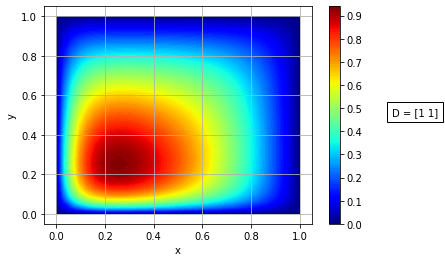

In [42]:
import matplotlib.pyplot as plt
import numpy as np

xy_plot = tp.domains.Parallelogram(X*Y, [0, 0], [w, 0], [0, h])
plot_sampler = tp.samplers.PlotSampler(xy_plot, n_points=1000, 
                                       data_for_other_variables={'D': [1,1]})##

fig = tp.utils.plot(model, constrain_fn, plot_sampler, plot_type="contour_surface")#
#name = str(round(i/3.0, 3)) + "," + str(round(j/3.0, 3))

#plt.title('D=[1,1]')
plt.savefig("SGR_appr.Laplace_NN6.png")
plt.show()

In [30]:
#xy_plot = tp.domains.Parallelogram(X*Y, [0, 0], [w, 0], [0, h])
#
#for i in [-3,-2,-1,0,1,2,3]:
#    for j in [-3,-2,-1,0,1,2,3]:
#        plot_sampler = tp.samplers.PlotSampler(xy_plot, n_points=1000, 
#                                       data_for_other_variables={'D': [i/3,j/3]})
#        fig = tp.utils.plot(model, constrain_fn, plot_sampler, plot_type="contour_surface")

In [46]:
import time
# Ausgabe des Maximum der Lösung
N = 200

## Gitter erzeugen
xi = np.linspace(0,1,N)
yi = np.linspace(0,1,N)
XX, YY = np.meshgrid(xi, yi)

## In Tensor umwandeln
in_data = torch.zeros((N**2, 4))
in_data[:, :1]  = torch.tensor(XX).reshape(-1, 1)
in_data[:, 1:2] = torch.tensor(YY).reshape(-1, 1)
     
in_data[:, 2] = 0
in_data[:, 3] = 0

## Model laden und mit constrains kombinieren
t1 = time.time()
out = model(tp.spaces.Points(in_data, X*Y*D)).as_tensor.detach()
out = constrain_fn(out, in_data[:, :1], in_data[:, 1:2])
t2 = time.time()
print('Zeit = ', t2-t1)
print('Maximum = ',torch.max(out))

Zeit =  0.010128498077392578
Maximum =  tensor(1.4519)


In [44]:
torch.save(model.state_dict(), 'PDE_SGR_adap_Laplace_NN4.pt')